In [1]:
import numpy as np
import os
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torch.nn.init as init
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display
import librosa
import zipfile
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import time
from PIL import Image
import copy
from collections import Counter
import cv2
torch.cuda.empty_cache()

In [3]:
from melspecdataset import MelSpecDataset

In [12]:
%pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 19.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Optionally resize images
    transforms.ToTensor(),            # Convert images to tensors
])


# Define the mapping from class names to class indices
class_mapping = {
    'car_horn': 1,
    'dog_barking': 2,
    'drilling': 3,
    'Fart': 4,
    'Guitar': 5,
    'Gunshot_and_gunfire': 6,
    'Hi-hat': 7,
    'Knock': 8,
    'Laughter': 9,
    'Shatter': 10,
    'siren': 11,
    'Snare_drum': 12,
    'Splash_and_splatter': 13
}

# Define the directories
train_directory = "train"
val_directory = "val"

# Create datasets
train_dataset = MelSpecDataset(train_directory, class_mapping, transform)
val_dataset = MelSpecDataset(val_directory, class_mapping, transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


datasets = {"train": train_dataset, "val": val_dataset}
dataloaders = {"train": train_dataloader, "val": val_dataloader}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

In [5]:
train_dataset.class_data, sum(train_dataset.class_data.values())

({'Snare_drum': 1000,
  'siren': 1000,
  'Hi-hat': 1000,
  'Gunshot_and_gunfire': 1000,
  'car_horn': 1000,
  'drilling': 1000,
  'Guitar': 1000,
  'Fart': 1000,
  'Laughter': 1000,
  'Splash_and_splatter': 1000,
  'dog_barking': 1000,
  'Shatter': 1000,
  'Knock': 1000},
 13000)

In [6]:
class SimplifiedResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SimplifiedResNet, self).__init__()
        self.in_channels = 32  # Reduced number of initial channels

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet blocks
        self.layer1 = self._make_layer(ResNetBlockSimple, self.in_channels, blocks=2, stride=1)
        self.layer2 = self._make_layer(ResNetBlockSimple, self.layer1[0].conv2.out_channels, blocks=2, stride=2)
        self.layer3 = self._make_layer(ResNetBlockSimple, self.layer2[0].conv2.out_channels, blocks=2, stride=2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(self.layer3[0].conv2.out_channels, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResNetBlockSimple(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlockSimple, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out



In [7]:
def save_model(model, model_name):
  torch.save(model.state_dict(), f'{model_name}_weights.pth')
  torch.save(model, f'{model_name}.pth')

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        print("HELLO")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            index = 0
            print("STARTING ITERATION")
            for inputs, labels in dataloaders[phase]:
              print("BATCH NUMBER = ", index)
              # inputs = inputs.to(device)
              # labels = labels.to(device)

              index += 1
              optimizer.zero_grad()
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
              print("STEPPING SCEHEDULER")
              scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'EPOCH: {epoch} {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model weights for the model which has the highest acc.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Define input shape and number of classes
input_shape = (128, 345, 3)
num_classes = 13  # Assuming 14 output classes

# Instantiate the model
model_ft = SimplifiedResNet(input_shape, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)


#DIFFERENT SCHEDULER THIS TIME
exp_lr_scheduler =  lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = model_ft.to(device)

In [ ]:
# [SimplifiedResNet] AUGMENTED [& ENSURED VAL HAS BEEN PREPROCESSED]
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
HELLO
STARTING ITERATION
BATCH NUMBER =  0
BATCH NUMBER =  1
BATCH NUMBER =  2
BATCH NUMBER =  3
BATCH NUMBER =  4
BATCH NUMBER =  5
BATCH NUMBER =  6
BATCH NUMBER =  7
BATCH NUMBER =  8
BATCH NUMBER =  9
BATCH NUMBER =  10
BATCH NUMBER =  11
BATCH NUMBER =  12
BATCH NUMBER =  13
BATCH NUMBER =  14
BATCH NUMBER =  15
BATCH NUMBER =  16
BATCH NUMBER =  17
BATCH NUMBER =  18
BATCH NUMBER =  19
BATCH NUMBER =  20
BATCH NUMBER =  21
BATCH NUMBER =  22
BATCH NUMBER =  23
BATCH NUMBER =  24
BATCH NUMBER =  25
BATCH NUMBER =  26
BATCH NUMBER =  27
BATCH NUMBER =  28
BATCH NUMBER =  29
BATCH NUMBER =  30
BATCH NUMBER =  31
BATCH NUMBER =  32
BATCH NUMBER =  33
BATCH NUMBER =  34
BATCH NUMBER =  35
BATCH NUMBER =  36
BATCH NUMBER =  37
BATCH NUMBER =  38
BATCH NUMBER =  39
BATCH NUMBER =  40
BATCH NUMBER =  41
BATCH NUMBER =  42
BATCH NUMBER =  43
BATCH NUMBER =  44
BATCH NUMBER =  45
BATCH NUMBER =  46
BATCH NUMBER =  47
BATCH NUMBER =  48
BATCH NUMBER =  49
BATCH NUMBER =

In [23]:
save_model(model_ft, "SimpleResNetStepSchedule")

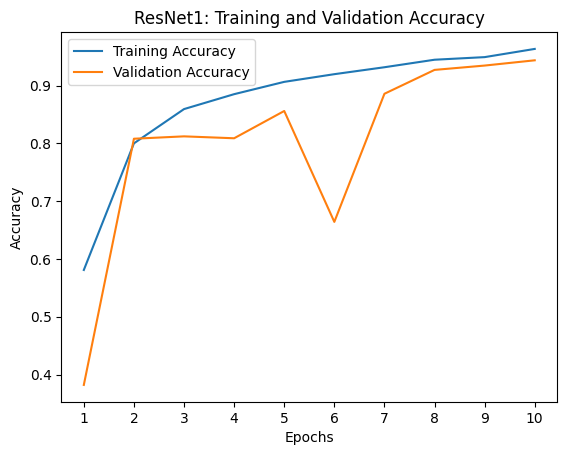

In [26]:
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = 10

# Define training and validation accuracy values
train_acc = [0.5810, 0.8001, 0.8594, 0.8852, 0.9065, 0.9198, 0.9318, 0.9448, 0.9493, 0.9635]
val_acc = [0.3821, 0.8081, 0.8122, 0.8089, 0.8561, 0.6642, 0.8859, 0.9272, 0.9347, 0.9438]

# Create x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet1: Training and Validation Accuracy')
plt.xticks(epochs)
plt.legend()

# Display the plot
plt.savefig("resnet1 accuracies.png")
plt.show()
